# Projet Neural Network - Corporación Favorita Grocery Sales Forecasting

Brick-and-mortar grocery stores are always in a delicate dance with purchasing and sales forecasting. Predict a little over, and grocers are stuck with overstocked, perishable goods. Guess a little under, and popular items quickly sell out, leaving money on the table and customers fuming.

The problem becomes more complex as retailers add new locations with unique needs, new products, ever transitioning seasonal tastes, and unpredictable product marketing. Corporación Favorita, a large Ecuadorian-based grocery retailer, knows this all too well. They operate hundreds of supermarkets, with over 200,000 different products on their shelves.

Corporación Favorita has challenged the Kaggle community to build a model that more accurately forecasts product sales. They currently rely on subjective forecasting methods with very little data to back them up and very little automation to execute plans. They’re excited to see how machine learning could better ensure they please customers by having just enough of the right products at the right time.

## I - Imports

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random as rd
from tqdm import tqdm

from neural_network import neural_net_model

/Users/louisgiron/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/Users/louisgiron/Desktop/ENSAE - Mastère spé/Reseaux de neurones/projet_nn/processing_data.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_small['unit_sales'] = train_small['unit_sales'].apply(lambda x:


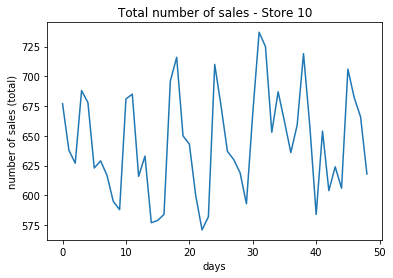

              Number of missing values  Share of missing
id                                   0              0.00
date                                 0              0.00
store_nbr                            0              0.00
item_nbr                             0              0.00
unit_sales                           0              0.00
onpromotion                    2000000            100.00
city                                 0              0.00
state                                0              0.00
type_x                               0              0.00
cluster                              0              0.00
dcoilwtico                      679683             33.98
type_y                         1836211             91.81
locale                         1836211             91.81
locale_name                    1836211             91.81
description                    1836211             91.81
transferred                    1836211             91.81
family                         

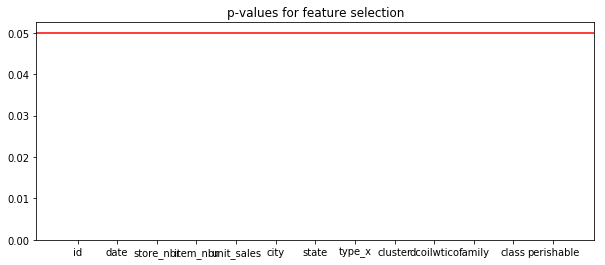

X train original shape: (125497040, 6)
X train processed shape: (2000000, 13)


In [2]:
from processing_data import train_all_processed

## II - Training setup

In [3]:
# Train size
train_size = 0.6

# Split the train data to learn # Warning date -> split linearly
X_train = train_all_processed.drop(['unit_sales'],
                                   axis=1).loc[range(int(train_all_processed.shape[0]*train_size))]
y_train = train_all_processed['unit_sales'].loc[range(int(train_all_processed.shape[0]*train_size))]
X_test = train_all_processed.drop(['unit_sales'],
                                   axis=1).loc[range(int(train_all_processed.shape[0]*train_size),
                                               int(train_all_processed.shape[0]))]
y_test = train_all_processed['unit_sales'].loc[range(int(train_all_processed.shape[0]*train_size),
                                               int(train_all_processed.shape[0]))]
# Norlmalize data
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train.values)
y_train_norm = scaler.fit_transform(y_train.values.reshape(-1, 1))

X_test_norm = scaler.fit_transform(X_test.values)
y_test_norm = scaler.fit_transform(y_test.values.reshape(-1, 1))

print(X_train.shape)
print(np.max(X_train_norm), np.max(y_train_norm), np.min(y_train_norm),
      np.min(y_train_norm))


def denormalize(y_train, norm_data):
    try:
        df = y_train.values.reshape(-1, 1)
    except AttributeError:
        df = y_train.reshape(-1, 1)
    norm_data = norm_data.reshape(-1, 1)
    scl = MinMaxScaler()
    scl.fit_transform(df)
    return scl.inverse_transform(norm_data)


# Input data
nb_input = X_train.shape[1]
nb_hidden1 = 64
nb_hidden2 = 64
batch_size = 10000
nb_epoch = 30

(1200000, 12)
1.0 1.0 0.0 0.0


## III - Model initialization

In [11]:
# Initialize the model
X_tf = tf.placeholder(tf.float32)
y_tf = tf.placeholder(tf.float32)
keep_prob_1 = tf.placeholder(tf.float32)
keep_prob_2 = tf.placeholder(tf.float32)

output, W_O = neural_net_model(X_tf, nb_input, nb_hidden1, nb_hidden2,
                               keep_prob_1, keep_prob_2)

cost = tf.reduce_mean(tf.square(output-y_tf))
train = tf.train.AdamOptimizer(0.001).minimize(cost)

correct_pred = tf.argmax(output, 1)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

c_t = []
c_test = []
err_t = []  # norm l2
err_test = []

# Drop out level
prob_1 = 0.1
prob_2 = 0.1

prob_out = 1.0

## IV - Model training

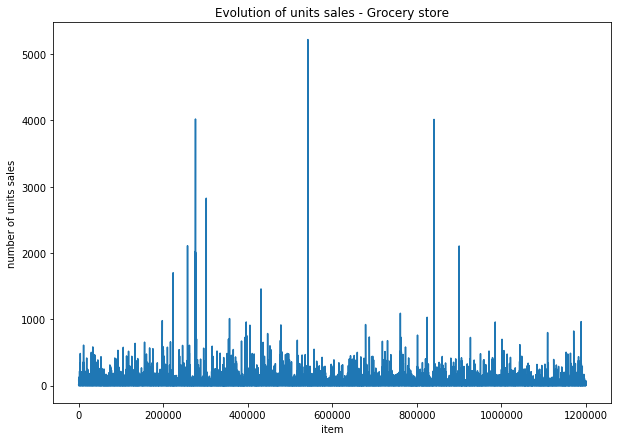


  3%|▎         | 1/30 [00:05<02:46,  5.74s/it]

Epoch : 0 Cost : 18.914974 Err (l2) : 357905.3233466708



  7%|▋         | 2/30 [00:11<02:39,  5.68s/it]

Epoch : 1 Cost : 0.18468818 Err (l2) : 28597.207588679958



 10%|█         | 3/30 [00:16<02:32,  5.66s/it]

Epoch : 2 Cost : 0.016532345 Err (l2) : 14117.793572624078



 13%|█▎        | 4/30 [00:22<02:28,  5.69s/it]

Epoch : 3 Cost : 0.00081971486 Err (l2) : 1883.6603763251874



 17%|█▋        | 5/30 [00:28<02:21,  5.68s/it]

Epoch : 4 Cost : 0.00051198836 Err (l2) : 2333.9879549032275



 20%|██        | 6/30 [00:34<02:20,  5.83s/it]

Epoch : 5 Cost : 0.0006554802 Err (l2) : 3165.4265112906005



 23%|██▎       | 7/30 [00:40<02:17,  5.98s/it]

Epoch : 6 Cost : 5.489905e-05 Err (l2) : 3113.0076390769245



 27%|██▋       | 8/30 [00:46<02:12,  6.03s/it]

Epoch : 7 Cost : 2.335772e-05 Err (l2) : 1831.1400876465611



 30%|███       | 9/30 [00:52<02:05,  6.00s/it]

Epoch : 8 Cost : 2.5733954e-05 Err (l2) : 2498.0155488212167



 33%|███▎      | 10/30 [00:58<01:59,  5.98s/it]

Epoch : 9 Cost : 1.2299804e-05 Err (l2) : 1780.2945323470817



 37%|███▋      | 11/30 [01:04<01:53,  5.98s/it]

Epoch : 10 Cost : 5.7340818e-05 Err (l2) : 2089.807703972433



 40%|████      | 12/30 [01:10<01:47,  5.96s/it]

Epoch : 11 Cost : 0.00025649162 Err (l2) : 1607.7658641139626



 43%|████▎     | 13/30 [01:16<01:40,  5.94s/it]

Epoch : 12 Cost : 0.0009181625 Err (l2) : 3331.983661977576



 47%|████▋     | 14/30 [01:22<01:34,  5.92s/it]

Epoch : 13 Cost : 5.175713e-05 Err (l2) : 4003.5779902664876



 50%|█████     | 15/30 [01:28<01:28,  5.91s/it]

Epoch : 14 Cost : 5.0163408e-06 Err (l2) : 1303.813964511386



 53%|█████▎    | 16/30 [01:34<01:22,  5.92s/it]

Epoch : 15 Cost : 6.7873807e-06 Err (l2) : 1427.655207437712



 57%|█████▋    | 17/30 [01:40<01:16,  5.91s/it]

Epoch : 16 Cost : 7.658296e-06 Err (l2) : 1230.3007847473086



 60%|██████    | 18/30 [01:46<01:10,  5.91s/it]

Epoch : 17 Cost : 0.00047247543 Err (l2) : 1452.8021314046837



 63%|██████▎   | 19/30 [01:51<01:04,  5.89s/it]

Epoch : 18 Cost : 1.38790965e-05 Err (l2) : 1925.7699424611135



 67%|██████▋   | 20/30 [01:57<00:58,  5.89s/it]

Epoch : 19 Cost : 7.734104e-06 Err (l2) : 1694.8986531069097



 70%|███████   | 21/30 [02:03<00:53,  5.89s/it]

Epoch : 20 Cost : 1.516709e-05 Err (l2) : 2283.5534735440747



 73%|███████▎  | 22/30 [02:09<00:47,  5.92s/it]

Epoch : 21 Cost : 0.0002960681 Err (l2) : 7799.679445284311



 77%|███████▋  | 23/30 [02:15<00:41,  5.91s/it]

Epoch : 22 Cost : 1.8587494e-05 Err (l2) : 2490.4514782718056


In [ ]:
# Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    saver = tf.train.Saver()
    y_t = denormalize(y_train, y_train_norm)
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(1, 1, 1)
    plt.xlabel('item')
    plt.ylabel('number of units sales')
    plt.title('Evolution of units sales - Grocery store')
    ax.plot(range(len(y_train)), y_t, label='Original')
    plt.show()

    try:
        saver.restore(sess, 'NN_favorita_grocery_sales.ckpt')
    except Exception:
        pass

    for i in tqdm(range(nb_epoch)):

        # Define and create batch samples
        batch_start = rd.randint(0, X_train_norm.shape[0]-batch_size)

        X_train_norm_batch = X_train_norm[np.arange(batch_start,
                                                    batch_start+batch_size),
                                          :]
        X_train_batch = X_train.loc[np.arange(batch_start,
                                              batch_start+batch_size)]

        y_train_norm_batch = y_train_norm[np.arange(batch_start,
                                                    batch_start+batch_size)].reshape(-1, 1)
        y_train_batch = y_train.loc[np.arange(batch_start,
                                              batch_start+batch_size)]
        y_train_batch = np.array(y_train_batch).reshape(-1, 1)

        # Run training on batch
        for j in range(X_train_norm_batch.shape[0]):
            sess.run([cost, train],
                     feed_dict={X_tf: X_train_norm_batch[j, :].reshape(1, nb_input),
                                y_tf: y_train_norm_batch[j],
                                keep_prob_1: prob_1,
                                keep_prob_2: prob_2})
        pred = sess.run(output, feed_dict={X_tf: X_train_norm_batch,
                                           keep_prob_1: prob_out,
                                           keep_prob_2: prob_out})
        pred = denormalize(y_train_batch, pred)

        # Compute the accuracy
        err_t.append(np.linalg.norm(pred - y_train_batch))
        c_t.append(sess.run(cost, feed_dict={X_tf: X_train_norm_batch,
                                             y_tf: y_train_norm_batch,
                                             keep_prob_1: prob_out,
                                             keep_prob_2: prob_out}))
        c_test.append(sess.run(cost, feed_dict={X_tf: X_test_norm,
                                                y_tf: y_test_norm,
                                                keep_prob_1: prob_out,
                                                keep_prob_2: prob_out}))
        print('Epoch :', i, 'Cost :', c_t[i], 'Err (l2) :', err_t[i])

    pred = sess.run(output, feed_dict={X_tf: X_test_norm,
                                       keep_prob_1: 1.0,
                                       keep_prob_2: 1.0})

    print('Cost :', sess.run(cost, feed_dict={X_tf: X_test_norm,
                                              y_tf: y_test_norm,
                                              keep_prob_1: 1.0,
                                              keep_prob_2: 1.0}))
    y_test = denormalize(y_test, y_test_norm)
    pred = denormalize(y_test, pred)

    # Save the model
    if input('Save model ? [Y/N]') == 'Y':
        import os
        saver.save(sess, os.getcwd() +
                   '/nn_saved_sessions/NN_favorita_grocery_sales.ckpt')
        print('Model Saved')

    # Close the session
    sess.close()

## V - Visualisation

In [ ]:
# Plot the accuracy as l2 norm
plt.figure(figsize=(10, 6))
plt.plot(range(nb_epoch), err_t, label="err (l2 norm)")
plt.legend(loc='best')
plt.ylabel('l2 norm - error of the prediction')
plt.xlabel('epochs')
plt.title('Evolution of the error of the prediction through epochs')
plt.show()

In [ ]:
# Plot the prediction vs the original
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), y_test, label="Original Data")
plt.plot(range(y_test.shape[0]), pred, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('Days')
plt.title('Evolution of units sales - Grocery store')
plt.show()

In [ ]:
# Plot the only the predictions
plt.figure(figsize=(10, 6))
plt.plot(range(y_test.shape[0]), pred, label="Predicted Data")
plt.legend(loc='best')
plt.ylabel('units sales')
plt.xlabel('Days')
plt.title('Evolution of units sales - Grocery store')
plt.show()